In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from PIL import Image

In [2]:
# TODO: Define transformations for both image and mask
# Resize the image to 256x256 with interpolation mode with proper kind of interpolation
# Resize the mask to 256x256 with interpolation mode with proper kind of interpolation
# Convert the image to tensor
# Convert the mask to tensor

class SegmentationTransform:
    def __init__(self, size=(256, 256)):
        # === TODO ===
        self.image_transform = T.Compose([
            T.ToTensor(),
            T.Resize(size, interpolation=Image.BICUBIC)
        ])

        # === === ===

        # === TODO ===
        self.mask_transform = T.Compose([
            T.ToTensor(),
            T.Resize(size, interpolation=Image.NEAREST)
        ])
        # === === ===

    def __call__(self, img, mask):
        img = self.image_transform(img)
        mask = self.mask_transform(mask).squeeze(0)  # Remove channel dim
        return img, mask
    
# Dataset with consistent transforms
transform = SegmentationTransform()

# Load Pascal VOC dataset
train_dataset = VOCSegmentation(
    root='./datasets',
    year='2012',
    image_set='train',
    download=True,
    transforms=transform
)

val_dataset = VOCSegmentation(
    root='./datasets',
    year='2012',
    image_set='val',
    download=True,
    transforms=transform
)

voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

assert len(train_dataset) == 1464
assert len(val_dataset) == 1449
assert train_dataset[0][0].shape == (3, 256, 256)
assert train_dataset[0][1].shape == (256, 256)

Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True).requires_grad_(False).to(DEVICE)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


/var/home/gabechu/miniconda3/envs/edf/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/home/gabechu/miniconda3/envs/edf/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]
unique_vals = torch.tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314, 0.0353, 
                            0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706, 0.0745, 
                            0.0784])

In [10]:
def transform_image(img):
    # [batch_size, 3, 256, 256] -> [batch_size, 256, 256, 3]
    if len(img.shape) == 4 and img.shape[1:] == (3, 256, 256):
        img = img.permute(0, 2, 3, 1)
    # [3, 256, 256] -> [256, 256, 3]
    elif len(img.shape) == 3 and img.shape == (3, 256, 256):
        img = img.permute(1, 2, 0)
    
    # Normalize the tensor to range [0, 1]
    return (img - img.min()) / (img.max() - img.min())

def denormalize_mask(tensor) -> torch.Tensor:
    # Ensure tensor has the correct shape
    assert tensor.shape[1:] == (256, 256) or tensor.shape == (256, 256)
    tensor[tensor == 1] = 0 # Remove background
    return (tensor*257).int()

def apply_colormap(mask: torch.Tensor, colormap: torch.Tensor) -> torch.Tensor:
    if mask.shape[1:] == (256, 256):
        return colormap[mask].permute(0, 3, 1, 2)
    elif mask.shape == (256, 256):
        return colormap[mask].permute(2, 0, 1)
    else:
        raise ValueError("Invalid shape, must be either (256, 256) or (batch_size, 256, 256)")


In [11]:
images, masks = next(iter(DataLoader(train_dataset, batch_size=4)))
images.to(DEVICE); masks.to(DEVICE)
model.eval(); 1

1

In [13]:
denormalized_masks = denormalize_mask(masks)
assert masks.shape == (4, 256, 256), f"{masks.shape}"
assert masks.dtype == torch.float32, f"{masks.dtype}"
assert denormalized_masks.shape == (4, 256, 256), f"{denormalized_masks.shape}"
assert denormalized_masks.dtype == torch.int32, f"{denormalized_masks.dtype}"

tensor_colormap = torch.tensor(VOC_COLORMAP, dtype=torch.uint8).cpu()
plottable_masks = apply_colormap(denormalized_masks, tensor_colormap)
assert plottable_masks.shape == (4, 3, 256, 256), f"{plottable_masks.shape}"
assert plottable_masks.dtype == torch.uint8, f"{plottable_masks.dtype}"

In [14]:
mask = denormalized_masks[0]
assert mask.dtype == torch.int64 or mask.dtype == torch.int32, "Mask must have integer values"
assert mask.min() >= 0 and mask.max() <= 20, "Mask values must be between 0 and 20"
assert mask.shape == (256, 256), f"Expected mask shape (256, 256), but got {mask.shape}"

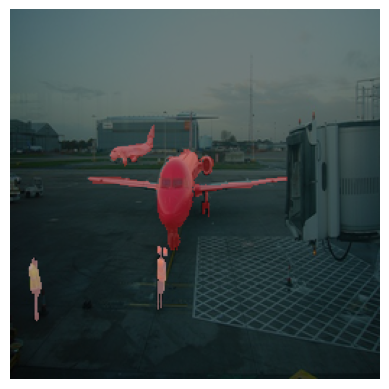

tensor([0.0000, 0.6667, 1.0000])


In [15]:
plottable_images = transform_image(images)
denormalized_masks = denormalize_mask(masks)
tensor_colormap = torch.tensor(VOC_COLORMAP, dtype=torch.uint8).cpu()
mask_images = apply_colormap(denormalized_masks, tensor_colormap)
plottable_masks = transform_image(mask_images)

index = 0

plt.imshow(plottable_masks[index])
plt.imshow(plottable_images[index], alpha=0.5)
plt.axis('off')
plt.show()
print(plottable_masks[index].unique())



Starting plotting...


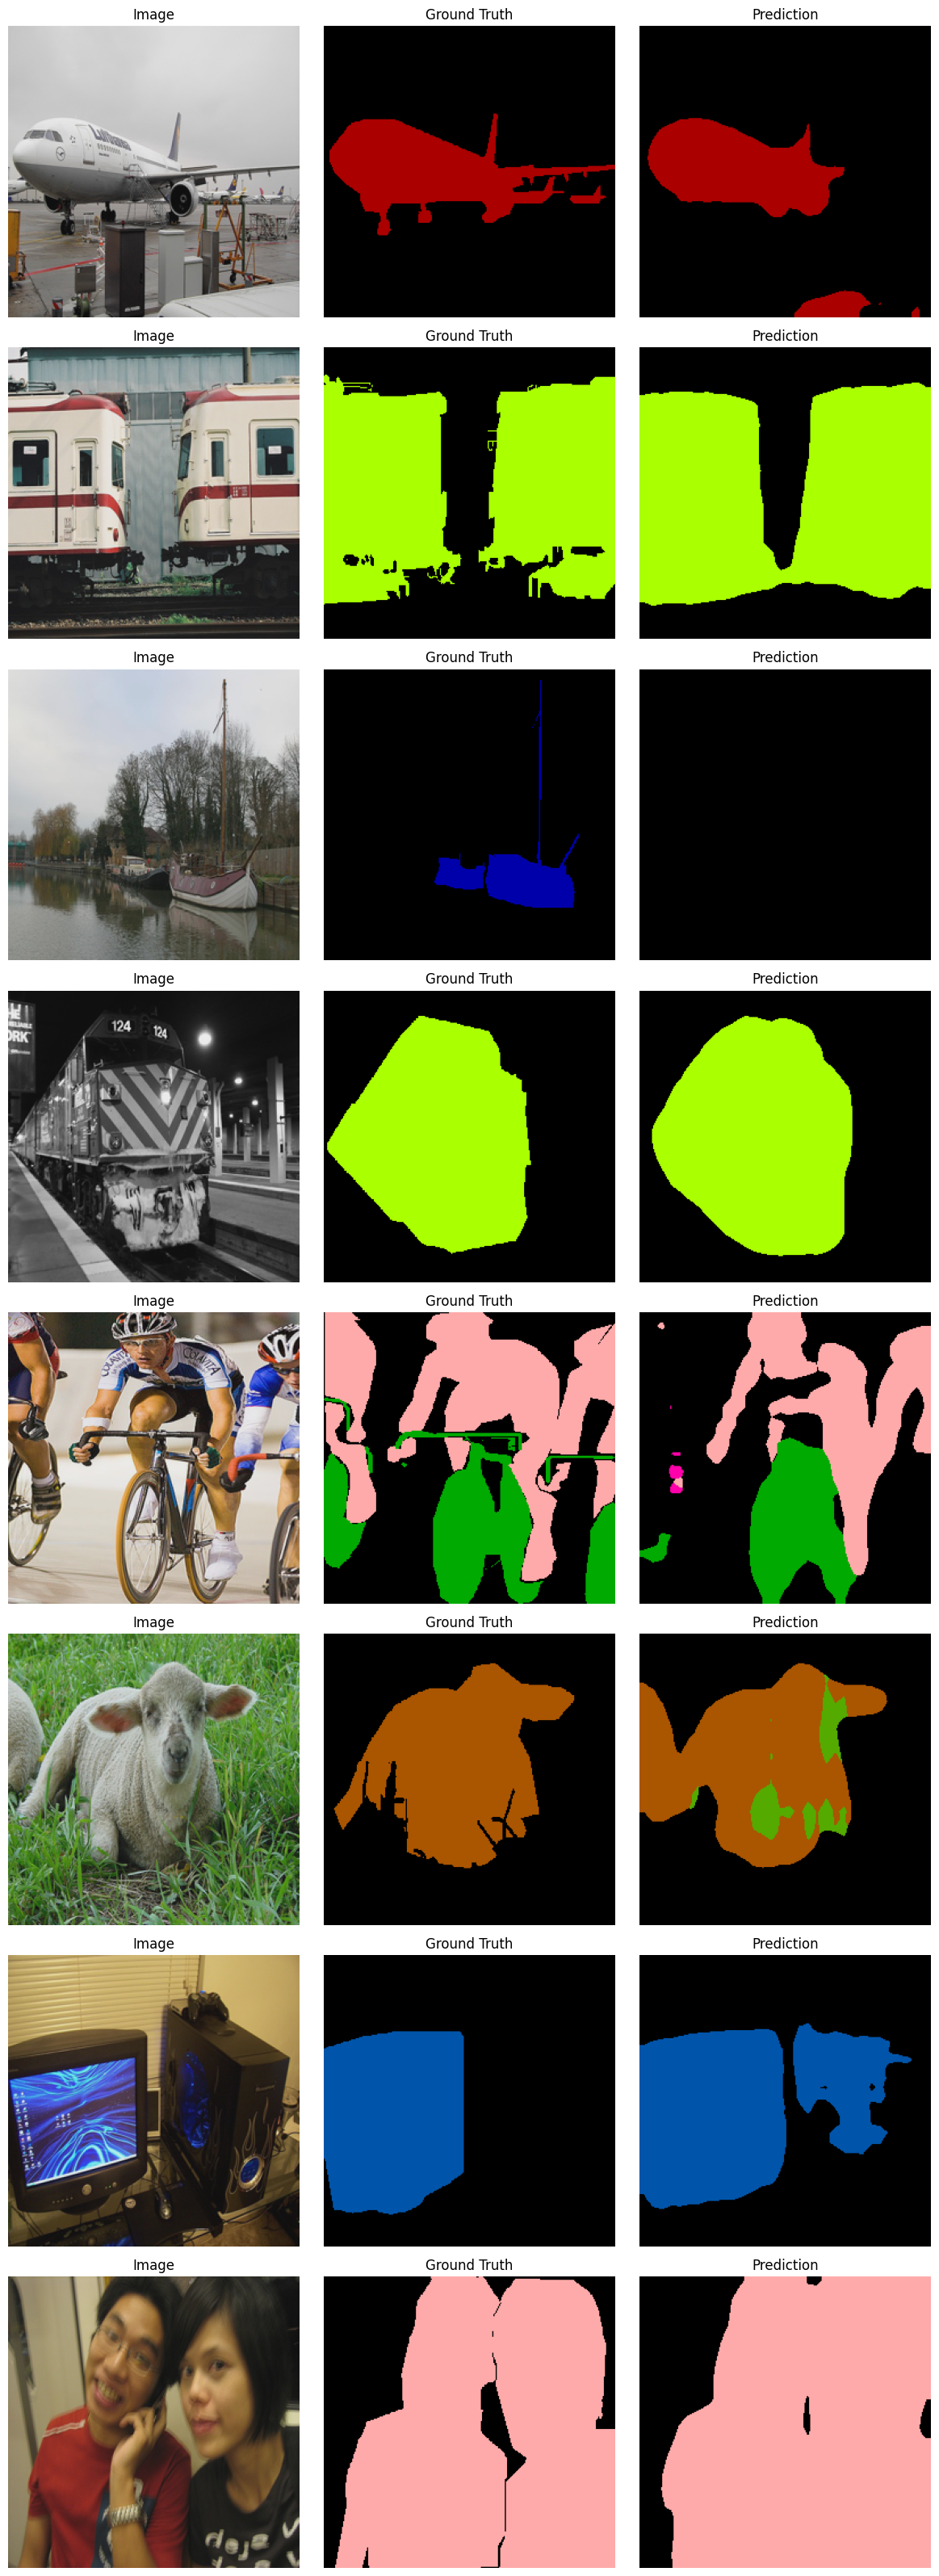

In [23]:
def visualize_predictions_with_voc_colors(model, dataloader, num_images, num_classes=21):
    images, masks = next(iter(dataloader))  # Load one batch
    images, masks = images[:num_images].to(DEVICE), masks[:num_images].to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)

    
    # Plotting
    images = transform_image(images)
    tensor_colormap = torch.tensor(VOC_COLORMAP, dtype=torch.uint8).cpu()
    masks = transform_image(apply_colormap(denormalize_mask(masks).cpu(), tensor_colormap))
    predictions = transform_image(apply_colormap(predictions.cpu(), tensor_colormap))
    
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    axes = axes.reshape(num_images, 3)
    
    print("Starting plotting...")
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].cpu())
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')
        
        # Plot ground truth mask
        axes[i, 1].imshow(masks[i].cpu())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        # # Plot prediction mask
        axes[i, 2].imshow(predictions[i])
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    # === === ===
visualize_predictions_with_voc_colors(model, val_loader, num_images=8)
